# Exploratory Data Analysis

## Project Background

Main reference: https://neo4j.com/developer-blog/diversify-your-stock-portfolio-with-graph-analytics/

Dataset: https://www.kaggle.com/datasets/kalilurrahman/nasdaq100-stock-price-data


This project, conducted from November to December 2024, focused on developing a community structure inference system for financial time series data. I led a team of three data scientists and leveraged graph algorithms and advanced data analysis techniques to create a powerful tool for asset portfolio evaluation. Later, I revisited the project to see where GPU-accelerated computations could help with create an ongoing community modularity optimization system for financial time series.

## Objectives

1. Develop a GPU-accelerated system for inferring community structures in financial time series data.
2. Engineer novel stock performance features using a large financial dataset.
3. Enable rolling performance evaluations of asset portfolios with "drill down" capability.
4. Demonstrate the power of CUDA and GPU acceleration in financial data analysis.

## In This Notebook
In this notebook, we cover the Exploratory Data Analysis phase of the project and utilize a basic GPU acceleration with Polars integration with RAPID (Nvidia). There is some explanation in the notebook and further reading links are provided.

**Install Pre-requisites**

In [5]:
# POLARS_GPU_ENABLE_CUDA_MANAGED_MEMORY set to 1 to avoid OOM errors in notebook
!export POLARS_GPU_ENABLE_CUDA_MANAGED_MEMORY=0

In [ ]:
!pip install polars[gpu] -U --extra-index-url=https://pypi.nvidia.com

In [6]:
# if running this in Google Colab - connect google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
import polars as pl
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns

To use a GPU, we just need to tell Polars to use the GPU engine when we call collect by passing engine="gpu" as a parameter.

`[polars operation returning pl.LazyFrame].collect(engine="gpu")`

The default configuration is likely the right choice for most workloads, but sometimes we want more control. We can provide more detailed configuration options (such as which device to run on and a variety of other options) by passing a Polars GPUEngine object to the engine parameter instead.

In this notebook, we'll use pl.GPUEngine. The default configuration has transparent CPU fallback for unsupported operations, so if we execute an unsupported query we don't get an error. To prove we're running on the GPU, we'll pass a configured engine object that will raise an error if we can't run the query.

In [10]:
# Enable GPU acceleration globally
gpu_engine = pl.GPUEngine(
    device=0, # This is the default
    raise_on_fail=True, # Fail loudly if we can't run on the GPU.
)

In [11]:
# import libraries
import kagglehub

# set this path to run
GDRIVE_MOUNT_POINT = "/content/gdrive/MyDrive/Portfolio_Berkeley/nasdaq_100.zip" #set path
dataset_path = GDRIVE_MOUNT_POINT

#!/bin/bash
! curl -L -o  {dataset_path} \
https://www.kaggle.com/api/v1/datasets/download/kalilurrahman/nasdaq100-stock-price-data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 6301k  100 6301k    0     0  2856k      0  0:00:02  0:00:02 --:--:-- 3514k


In [14]:
import shutil
# load data into local path
DOWNLOAD_PATH = "./nasdaq_100"
# unzip and extracted to specified directory
shutil.unpack_archive(f'{dataset_path}', DOWNLOAD_PATH)  # Extract to a specified directory

### Answering some early questions about the dataset

- How many individual stocks are there and what are the names

- Are there equivalent date ranges for each stock

- What is the distribution of stock trading volumes across the stocks

## Why Polars with GPU Acceleration?

We're leveraging Polars with GPU acceleration for this demo to significantly boost our data processing capabilities. Here's how this works:

1. **Query Construction**: When using `collect(engine="gpu")`, Polars first builds a Domain Specific Language (DSL) representation of the query, similar to an Abstract Syntax Tree (AST) in programming languages.

2. **IR Conversion and Optimization**: The DSL is converted to an Intermediate Representation (IR). This step involves:
   - Query validation
   - Metadata fetching/estimation
   - Schema determination for all operations
   - Query optimization (reordering, simplification, removal of redundant operations)

3. **CuDF Integration**: The optimized IR is passed to cuDF, which traverses the IR and attempts to replace entire subgraphs in the Directed Acyclic Graph (DAG) with Python callbacks that return DataFrames of the appropriate schema.

4. **Plan Building**: Using an inspector-executor design, cuDF inspects the Polars IR and builds a GPU execution plan if possible. This plan is returned to Polars without execution, allowing for efficient fallback to CPU if needed.

5. **GPU Execution**: If all operations are GPU-supported, cuDF builds its own physical plan representation. The top-most node in the Polars IR is replaced with an opaque function node that executes this GPU plan.

6. **Hybrid Execution**: Polars' in-memory engine executes the plan, transitioning to GPU execution when it reaches the cuDF node.


By using Polars with GPU acceleration we're able to demonstrate the Exploratory Data Analysis phase of the financial time series analysis and get a small snapshot of the performance improvement that can be expected here.

#### Further Reading on GPU Acceleration with Polars

If you are interested in diving deeper into GPU acceleration capabilities with Polars, here are some resources:

1. [Official Polars GPU Engine Release](https://pola.rs/posts/gpu-engine-release/)
   > Detailed technical overview of the new GPU acceleration features and implementation details of the NVIDIA RAPIDS integration.

2. [GPU Accelerated Polars – Intuitively and Exhaustively Explained](https://towardsdatascience.com/gpu-accelerated-polars-intuitively-and-exhaustively-explained-e823a82f92a8/)
   > A comprehensive practical guide that breaks down how GPU acceleration works with Polars dataframes in simpler terms.

These resources will be particularly valuable as to understand as I move onto our modularity optimization analysis. The resources give more detail on how operations over larger datasets benefit from GPU acceleration.



In [17]:
import time
import pandas as pd

# Time pandas load
start = time.perf_counter()
pd_df = pd.read_csv("./nasdaq_100/NASDAQ_100_Data_From_2010.csv", sep="\t")
pd_time = time.perf_counter() - start
print(f"Pandas load time: {pd_time:.4f} seconds")

# Time polars load
start = time.perf_counter()
pl_df = pl.read_csv("./nasdaq_100/NASDAQ_100_Data_From_2010.csv", separator="\t")
pl_time = time.perf_counter() - start
print(f"Polars load time: {pl_time:.4f} seconds")

print(f"\nPolars is {pd_time/pl_time:.2f}x faster")
df = pl_df

Pandas load time: 0.6962 seconds
Polars load time: 0.2104 seconds

Polars is 3.31x faster


In [18]:
df.head(10)

Date,Open,High,Low,Close,Adj Close,Volume,Name
str,f64,f64,f64,f64,f64,i64,str
"""2010-01-04""",7.6225,7.660714,7.585,7.643214,6.562591,493729600,"""AAPL"""
"""2010-01-05""",7.664286,7.699643,7.616071,7.656429,6.573935,601904800,"""AAPL"""
"""2010-01-06""",7.656429,7.686786,7.526786,7.534643,6.469369,552160000,"""AAPL"""
"""2010-01-07""",7.5625,7.571429,7.466071,7.520714,6.457407,477131200,"""AAPL"""
"""2010-01-08""",7.510714,7.571429,7.466429,7.570714,6.500339,447610800,"""AAPL"""
"""2010-01-11""",7.6,7.607143,7.444643,7.503929,6.442997,462229600,"""AAPL"""
"""2010-01-12""",7.471071,7.491786,7.372143,7.418571,6.369709,594459600,"""AAPL"""
"""2010-01-13""",7.423929,7.533214,7.289286,7.523214,6.459555,605892000,"""AAPL"""
"""2010-01-14""",7.503929,7.516429,7.465,7.479643,6.422143,432894000,"""AAPL"""


In [22]:
# Check count and remove any NaN rows
nan_count = df.null_count().sum()
print(f"Number of rows with NaN values: {nan_count}")

Number of rows with NaN values: shape: (1, 8)
┌──────┬──────┬──────┬─────┬───────┬───────────┬────────┬──────┐
│ Date ┆ Open ┆ High ┆ Low ┆ Close ┆ Adj Close ┆ Volume ┆ Name │
│ ---  ┆ ---  ┆ ---  ┆ --- ┆ ---   ┆ ---       ┆ ---    ┆ ---  │
│ u32  ┆ u32  ┆ u32  ┆ u32 ┆ u32   ┆ u32       ┆ u32    ┆ u32  │
╞══════╪══════╪══════╪═════╪═══════╪═══════════╪════════╪══════╡
│ 0    ┆ 0    ┆ 0    ┆ 0   ┆ 0     ┆ 0         ┆ 0      ┆ 0    │
└──────┴──────┴──────┴─────┴───────┴───────────┴────────┴──────┘


In [23]:
# ensure that Date column is read as a date
df = df.with_columns(pl.col("Date").str.strptime(pl.Date))

In [25]:
# How many individual stocks are there and what are the names
unique_stocks = df.get_column("Name").unique()
num_unique_stocks = len(unique_stocks)
print(f"There are {num_unique_stocks} unique stocks.")

There are 102 unique stocks.


In [29]:
def measure_date_range(df: pl.DataFrame) -> pl.DataFrame:
    """
    Measures the date ranges for each stock in the dataset
    """
    return (
        df.group_by("Name")
        .agg([
            ((pl.col("Date").max() - pl.col("Date").min()).dt.total_days()).alias("date_range")
        ])
    )

ranges = measure_date_range(df)
ranges.head()

Name,date_range
str,i64
"""CSCO""",4267
"""EBAY""",4267
"""EXC""",4267
"""PEP""",4267
"""GOOGL""",4267


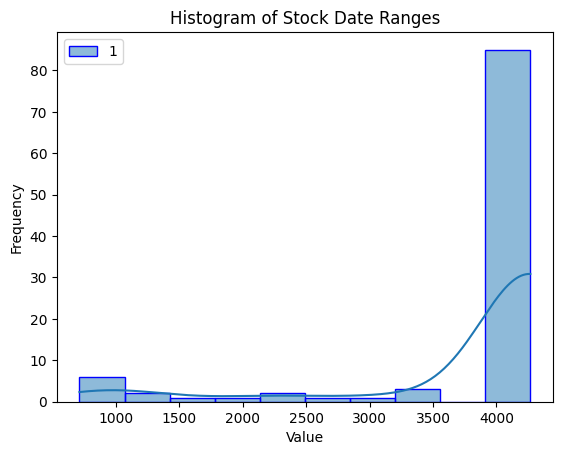

In [30]:
# check the distribution
# Create the histogram
sns.histplot(ranges, kde=True, bins=10, edgecolor='blue')

# Add titles and labels
plt.title('Histogram of Stock Date Ranges')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the plot
plt.show()

Note that there is an uneven distribution of stock date ranges. It appears that for a majority of stocks, we do have a date range of 4,000+ days. However, among the dataset there are some stocks with very little data comparatively by date range, and there looks to be a significant number of stocks with more constrained date ranges.


In [31]:
def measure_stock_volumes(df: pl.DataFrame) -> pl.DataFrame:
    """
    Measures volume statistics per stock using Polars aggregations
    """
    return (
        df.group_by("Name")
        .agg([
            ((pl.col("Date").max() - pl.col("Date").min()).dt.total_days()).alias("date_range"),
            pl.col("Volume").mean().round(1).alias("vol_mean"),
            pl.col("Volume").median().round(1).alias("vol_med"),
            pl.col("Volume").mean().round(1).alias("vol_avg")  # in this case avg = mean
        ])
    )

vols = measure_stock_volumes(df)
vols.head()

Name,date_range,vol_mean,vol_med,vol_avg
str,i64,f64,f64,f64
"""WDAY""",3255,1719147.1,1.41245e6,1719147.1
"""BIDU""",4267,5300761.8,3.7049e6,5300761.8
"""KLAC""",4267,1893288.9,1.5309e6,1893288.9
"""INCY""",4267,1595852.3,1.3397e6,1595852.3
"""ATVI""",4267,8306530.9,6.948e6,8306530.9


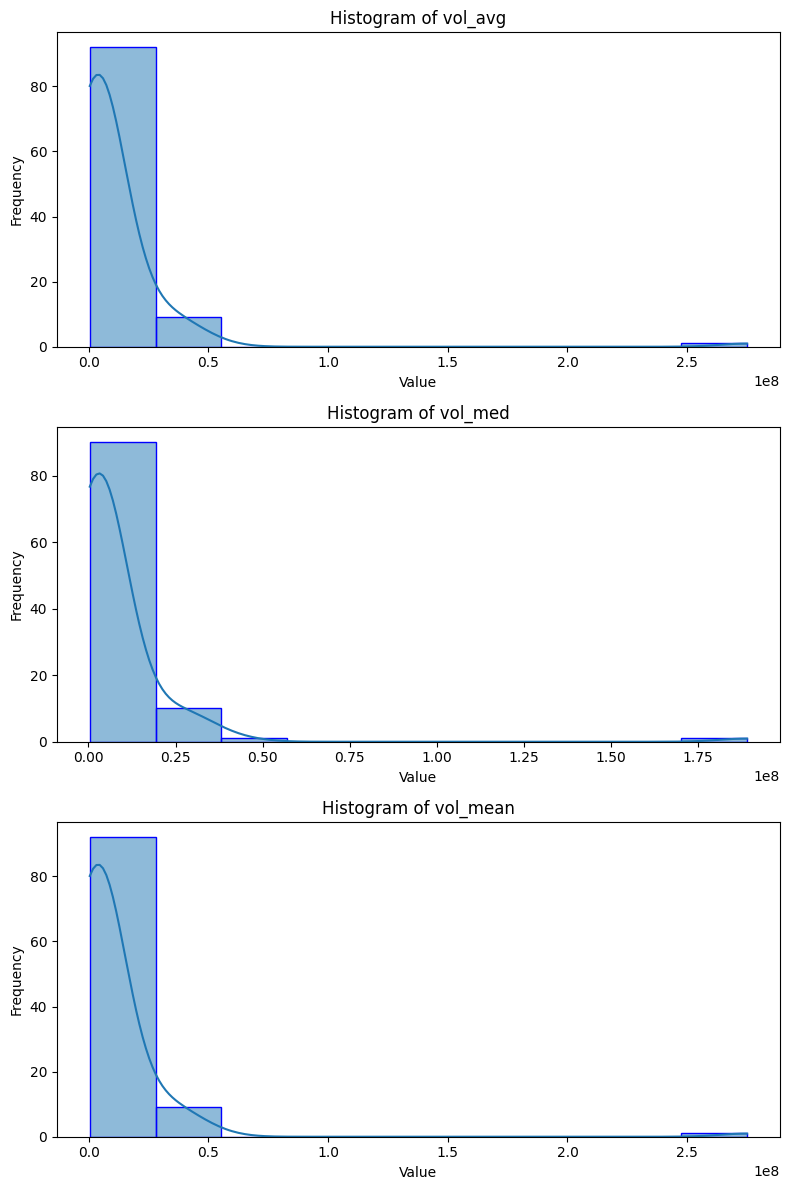

In [32]:
# what is the distribution of stock trade volumes among the dataset

# gather volume metrics
vol_metrics = ['vol_avg', 'vol_med', 'vol_mean']

# Create a figure with 3 subplots arranged vertically (3x1)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

# Iterate over the volume metrics and plot each one
for ax, col_name in zip(axes, vol_metrics):
    # Create the histogram for each volume metric
    sns.histplot(vols[col_name], kde=True, ax=ax, bins=10, edgecolor='blue')

    # Add titles and labels for each subplot
    ax.set_title(f'Histogram of {col_name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


We have plotted the average, mean, and median volume distributions across all stocks in the dataset. It appears that there is some similarity among stock volumes, and there are few outliers as well.


## Feature Engineering
The goal of feature engineering in our case is to create a "stock performance" feature that maintains the ordinality of the dataset, i.e. maintains the sequential daily index.
- In this section, we engineer daily stock performance features using the following standard formulas.

# Price Change Percentage
The formula for Price Change Percentage is:

$$
\text{Price Change (\%)} = \left( \frac{\text{Close Price} - \text{Open Price}}{\text{Open Price}} \right) \times 100
$$

# Volume-Weighted Average Price (VWAP)
The formula for VWAP is:

$$
\text{VWAP} = \frac{\sum_{i=1}^{n} (\text{Price}_i \times \text{Volume}_i)}{\sum_{i=1}^{n} \text{Volume}_i}
$$
where *n* is the number of time intervals.

Note: In the case of PCP and VWAP, the time internal is daily and thus a bit negligible as *n* will always be one. This metric is still valuable because we're able to give weight by daily volume for the stock.

# Time-Weighted Average Price (TWAP)
The formula for TWAP is:

$$
\text{TWAP} = \frac{\sum_{i=1}^{n} \text{Price}_i}{n}
$$
where *n* is the number of time intervals.

Note: In the case of TWAP, we have to engineer a separate data structure and graph to analyze the TWAP because if *n* is one each time, we're not able to derive useful information. The sum of daily price is simply the sum of that daily price.


# Price Volatility

The daily price volatility is calculated as a percentage of the opening price:

$$
\text{Volatility} = \frac{\text{High} - \text{Low}}{\text{Open}} \times 100\%
$$

Where:
- \(High\): The highest price of the day
- \(Low\): The lowest price of the day
- \(Open\): The opening price of the day

This measure represents the maximum price range as a percentage of the opening price, giving us a normalized measure of daily price movement.



## Develop Volatility metric for the dataset

In [50]:
def calculate_daily_volatility(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        ((pl.col("High") - pl.col("Low")) / pl.col("Open") * 100).alias("volatility")
    ])

df_with_volatility = calculate_daily_volatility(df)
df_with_volatility.head()

Date,Open,High,Low,Close,Adj Close,Volume,Name,volatility
date,f64,f64,f64,f64,f64,i64,str,f64
2010-01-04,7.6225,7.660714,7.585,7.643214,6.562591,493729600,"""AAPL""",0.993298
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.573935,601904800,"""AAPL""",1.090407
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.469369,552160000,"""AAPL""",2.089751
2010-01-07,7.5625,7.571429,7.466071,7.520714,6.457407,477131200,"""AAPL""",1.393159
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.500339,447610800,"""AAPL""",1.397997


## Develop PCP for the dataset

In [51]:
# develop PCP for the dataset
def PCP(dataframe: pl.DataFrame) -> pl.DataFrame:
    return dataframe.with_columns(
        ((pl.col('Close') - pl.col('Open')) / pl.col('Open') * 100).alias('pcp')
    )

df_w_pcp = PCP(df_with_volatility)
df_w_pcp

Date,Open,High,Low,Close,Adj Close,Volume,Name,volatility,pcp
date,f64,f64,f64,f64,f64,i64,str,f64,f64
2010-01-04,7.6225,7.660714,7.585,7.643214,6.562591,493729600,"""AAPL""",0.993298,0.271752
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.573935,601904800,"""AAPL""",1.090407,-0.102519
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.469369,552160000,"""AAPL""",2.089751,-1.590632
2010-01-07,7.5625,7.571429,7.466071,7.520714,6.457407,477131200,"""AAPL""",1.393159,-0.552545
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.500339,447610800,"""AAPL""",1.397997,0.798858
…,…,…,…,…,…,…,…,…,…
2021-09-03,295.325012,301.804993,292.029999,298.290009,298.290009,6127900,"""ZM""",3.309911,1.003977
2021-09-07,298.295013,300.980011,294.799988,299.959991,299.959991,4251900,"""ZM""",2.071782,0.558165
2021-09-08,299.549988,299.959991,290.529999,293.600006,293.600006,3934400,"""ZM""",3.148053,-1.986307


In [58]:
# Check for days with zero volume
zero_volume_days = df_w_pcp.filter(pl.col('Volume') == 0)
print("Days with zero volume:")
print(f"Days with zero trade volume: {zero_volume_days.height}")

Days with zero volume:
Days with zero trade volume: 18


In [59]:
def VWAP(stock_list: list[str], dataframe: pl.DataFrame) -> pl.DataFrame:
    # Create expression for average price calculation
    avg_price = (pl.col('High') + pl.col('Low') + pl.col('Close')) / 3

    return (dataframe
        # Group by stock name to calculate average volume per stock
        .with_columns([
            pl.col('Volume').mean().over('Name').alias('avg_volume')
        ])
        # Replace 0 volumes with the stock's average volume
        .with_columns([
            pl.when(pl.col('Volume') == 0)
            .then(pl.col('avg_volume'))
            .otherwise(pl.col('Volume'))
            .alias('adj_volume')
        ])
        # Calculate VWAP
        .with_columns([
            (avg_price * pl.col('adj_volume') / pl.col('adj_volume')).alias('vwap')
        ])
        # Drop the temporary columns we created
        .drop(['avg_volume', 'adj_volume'])
    )

df_w_vwap = VWAP(stock_list=unique_stocks, dataframe=df_w_pcp)
df_w_vwap.head(5)

Date,Open,High,Low,Close,Adj Close,Volume,Name,volatility,pcp,vwap
date,f64,f64,f64,f64,f64,i64,str,f64,f64,f64
2010-01-04,7.6225,7.660714,7.585,7.643214,6.562591,493729600,"""AAPL""",0.993298,0.271752,7.629643
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.573935,601904800,"""AAPL""",1.090407,-0.102519,7.657381
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.469369,552160000,"""AAPL""",2.089751,-1.590632,7.582738
2010-01-07,7.5625,7.571429,7.466071,7.520714,6.457407,477131200,"""AAPL""",1.393159,-0.552545,7.519405
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.500339,447610800,"""AAPL""",1.397997,0.798858,7.536191


In [62]:
# Check for NaN values and remove rows with NaN before exporting

nan_count = df_w_vwap.null_count().sum()
print(f"Number of rows with NaN values: {nan_count}")

# Remove rows with NaN values
df_cleaned = df_w_vwap.drop_nulls()

# Display the cleaned DataFrame

print(f"DataFrame after removing rows with NaN values has {len(df_w_vwap)} rows.")

Number of rows with NaN values: shape: (1, 11)
┌──────┬──────┬──────┬─────┬───┬──────┬────────────┬─────┬──────┐
│ Date ┆ Open ┆ High ┆ Low ┆ … ┆ Name ┆ volatility ┆ pcp ┆ vwap │
│ ---  ┆ ---  ┆ ---  ┆ --- ┆   ┆ ---  ┆ ---        ┆ --- ┆ ---  │
│ u32  ┆ u32  ┆ u32  ┆ u32 ┆   ┆ u32  ┆ u32        ┆ u32 ┆ u32  │
╞══════╪══════╪══════╪═════╪═══╪══════╪════════════╪═════╪══════╡
│ 0    ┆ 0    ┆ 0    ┆ 0   ┆ … ┆ 0    ┆ 0          ┆ 0   ┆ 0    │
└──────┴──────┴──────┴─────┴───┴──────┴────────────┴─────┴──────┘
DataFrame after removing rows with NaN values has 271680 rows.


## Adding a Sharpe Ratio Dataset

I created a separate dataset for Sharpe calculations because this separation  makes computations more efficient and less likely to compromise data integrity.Sharpe calculations can be resource-intensive.

By keeping the raw price and VWAP data separate from risk calculations, I prevent accidental modifications to our base dataset and make debugging much simpler. I can then run risk calculations independently without having to recalculate VWAP metrics each time there's a change in risk parameters.

Most importantly, this modular approach lets me experiment with different risk metrics without touching core price data.


In [68]:
def calculate_sharpe_ratio(df: pl.DataFrame, risk_free_rate: float = 0.02) -> pl.DataFrame:
    # Pivot the data like the pandas version
    pivot_df = df.pivot(
        values='Close',
        index='Date',
        on='Name'
    )

    # Calculate daily returns - using pct_change over columns
    daily_returns = pivot_df.select([
        pl.col('*').exclude('Date').pct_change()
    ])

    # Calculate mean and std dev of returns
    mean_returns = daily_returns.mean()
    std_returns = daily_returns.std()

    # Calculate Sharpe ratio
    sharpe_ratios = (mean_returns - risk_free_rate) / std_returns

    # Convert to DataFrame with Name and Sharpe columns
    result = pl.DataFrame({
        'Name': pivot_df.columns[1:],  # Exclude Date column
        'Sharpe': sharpe_ratios.row(0)
    })

    return result

sharpe_ratios = calculate_sharpe_ratio(df)
sharpe_ratios

Name,Sharpe
str,f64
"""AAPL""",-1.060843
"""ADBE""",-0.994898
"""ADI""",-1.067723
"""ADP""",-1.408564
"""ADSK""",-0.841525
…,…
"""WBA""",-1.114499
"""WDAY""",-0.777108
"""XEL""",-1.635274


# Export Feature Engineered Dataset
## - Export a CSV of all original columns with `volatility`, `pcp`, and `vwap` engineered features
## - Export Sharpe Ratios as a csv

In [70]:
# G Drive path from above, leave commented
# GDRIVE_MOUNT_POINT = "/content/gdrive/MyDrive/Portfolio_Berkeley/nasdaq_100.zip"
g_drive_path = "/content/gdrive/MyDrive/Portfolio_Berkeley"


In [72]:
# Export df_w_vwap to a CSV file with additional options
df_w_vwap.write_csv(f'{g_drive_path}/df_w_vwap.csv', include_header=True, float_precision=4)

In [73]:
# Export sharpe ratios to a CSV file with additional options
sharpe_ratios.write_csv(f'{g_drive_path}/sharpe_ratios.csv', include_header=True, float_precision=4)

# Conclusion

If you've made it this far, thank you for following the walkthrough. If you ran this notebook along with me,  then we've successfully processed our stock market data by calculating VWAP to better understand trading volumes and price movements. Our analysis included cleaning the data by removing null values and handling zero-volume trading days. We then computed Sharpe ratios to evaluate risk-adjusted returns which gives us a clear picture of which stocks provide the best returns per unit of risk taken. All of this preprocessing and risk analysis sets us up perfectly for the next phase: running modularity optimization algorithms. These algorithms will help us identify natural clusters or communities of stocks that behave similarly which is crucial for the "drill down" analysis capability that we eventually want.

The modular approach taken here separating the data processing steps makes it easier to experiment with different optimization parameters in the next notebook. The cleaned and processed dataset with VWAP and Sharpe ratios gives the data foundational layer for the network analysis and community detection that follows.
